# Model for classification of triangles vs. squares

### Settings

In [14]:
# Imports
import warnings
warnings.simplefilter('ignore')

import numpy as np
from numpy import load
import os.path
import matplotlib.pyplot as plt

import keras.backend as K
if(K.tensorflow_backend):
    import tensorflow as tf
    tf.logging.set_verbosity(tf.logging.ERROR)
from keras.utils import np_utils
from keras.models import load_model

from code import shape_images as shi
from code import model as mod

### Loading of pre-generated data

In [15]:
# filenames
# data paths
original_data_path = "/home/elena/eStep/XAI/Data/TrianglesAndSquaresRotationScale"

train_data_fname = os.path.join(original_data_path, 'split_npz','train_data.npz')
test_data_fname = os.path.join(original_data_path, 'split_npz','test_data.npz')
val_data_fname = os.path.join(original_data_path, 'split_npz','validation_data.npz')

# loading
train_data = np.load(train_data_fname)
test_data = np.load(test_data_fname)
val_data = np.load(val_data_fname)


In [16]:
images_train = train_data['images_train']
labels_train = train_data['labels_train']
images_test = test_data['images_test']
labels_test_or = test_data['labels_test']
images_val = val_data['images_val']
labels_val = val_data['labels_val']

print("Size of training data: ", np.shape(images_train), "and labels: ", np.shape(labels_train))
print("Size of validation data: ", np.shape(images_val), "and labels: ", np.shape(labels_val))
print("Size of testing data: ", np.shape(images_test), "and labels: ", np.shape(labels_test_or))

Size of training data:  (14000, 4096) and labels:  (14000,)
Size of validation data:  (4000, 4096) and labels:  (4000,)
Size of testing data:  (2000, 4096) and labels:  (2000,)


#### Images formatting

In [17]:
img_rows = 64
img_cols = 64
#print(K.image_data_format())
if K.image_data_format() == 'channels_first':
    images_train = images_train.reshape(images_train.shape[0], 1, img_rows, img_cols)
    images_test = images_test.reshape(images_test.shape[0], 1, img_rows, img_cols)
    images_val = images_val.reshape(images_val.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    images_train = images_train.reshape(images_train.shape[0], img_rows, img_cols, 1)
    images_test = images_test.reshape(images_test.shape[0], img_rows, img_cols, 1)
    images_val = images_val.reshape(images_val.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)
print("Size of training data: ", np.shape(images_train))
print("Size of validation data: ", np.shape(images_val))
print("Size of testing data: ", np.shape(images_test))

Size of training data:  (14000, 64, 64, 1)
Size of validation data:  (4000, 64, 64, 1)
Size of testing data:  (2000, 64, 64, 1)


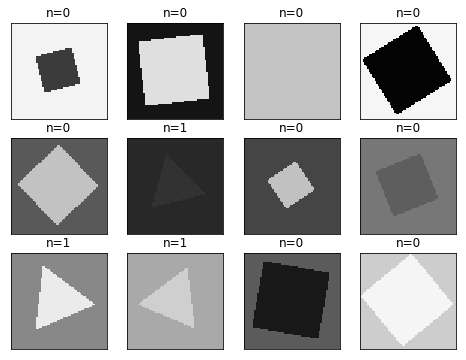

In [18]:
# plot 12 random train images
shi.plot_12images(images_train, labels_train) 

#### Labels formatting

In [19]:
# convert class vectors to binary class matrices
labels_train = np_utils.to_categorical(labels_train, num_classes=2)
labels_test = np_utils.to_categorical(labels_test_or, num_classes=2)
labels_val = np_utils.to_categorical(labels_val, num_classes=2)
print(labels_train)
print('labels_train shape:', labels_train.shape)
print('labels_test shape:', labels_test.shape)
print('labels_val shape:', labels_val.shape)

[[0. 1.]
 [0. 1.]
 [1. 0.]
 ...
 [1. 0.]
 [1. 0.]
 [0. 1.]]
labels_train shape: (14000, 2)
labels_test shape: (2000, 2)
labels_val shape: (4000, 2)


## CNN model

In [20]:
# parameters of the training
batch_size = 200
epochs = 5
num_classes = 2

In [21]:
# generate the model
model = mod.generate_model(input_shape, num_classes)

print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_layer1 (Conv2D)       (None, 62, 62, 64)        640       
_________________________________________________________________
conv2d_layer2 (Conv2D)       (None, 60, 60, 128)       73856     
_________________________________________________________________
maxpooling2d_layer1 (MaxPool (None, 30, 30, 128)       0         
_________________________________________________________________
dropout_layer1 (Dropout)     (None, 30, 30, 128)       0         
_________________________________________________________________
flatten_layer1 (Flatten)     (None, 115200)            0         
_________________________________________________________________
dense_layer1 (Dense)         (None, 256)               29491456  
_________________________________________________________________
dropout_layer2 (Dropout)     (None, 256)               0         
__________

In [22]:
# train 
mod.train_model(model, images_train, labels_train, images_val, labels_val, batch_size, epochs)

Train on 14000 samples, validate on 4000 samples
Epoch 1/5
14000/14000 [==============================] - 440s 31ms/step - loss: 0.7351 - acc: 0.5640 - val_loss: 0.6145 - val_acc: 0.6960
Epoch 2/5
14000/14000 [==============================] - 426s 30ms/step - loss: 0.5451 - acc: 0.7107 - val_loss: 0.3959 - val_acc: 0.8992
Epoch 3/5
14000/14000 [==============================] - 473s 34ms/step - loss: 0.3460 - acc: 0.8566 - val_loss: 0.1315 - val_acc: 0.9710
Epoch 4/5
14000/14000 [==============================] - 469s 33ms/step - loss: 0.1335 - acc: 0.9541 - val_loss: 0.0947 - val_acc: 0.9570
Epoch 5/5
14000/14000 [==============================] - 484s 35ms/step - loss: 0.1083 - acc: 0.9588 - val_loss: 0.0960 - val_acc: 0.9738


### Save the model

In [23]:
# filename for model saving
model_fname = os.path.join(original_data_path, 'Models','model.h5')

In [24]:
# save the trained model
model.save(model_fname)
print("Saved model to disk")

Saved model to disk


## Test the model

In [25]:
# load the trained model
model = load_model(model_fname) 
print("Loaded model from disk")

Loaded model from disk


In [26]:
score = model.evaluate(images_test, labels_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.10065763419866562
Test accuracy: 0.9765


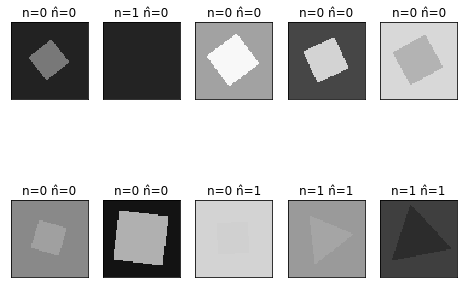

In [32]:
# pick up 10 random images and classify them using the trained model
import matplotlib.cm as cm

figsize = (8, 6)
plt.figure(figsize=figsize)
j=0
nim = len(labels_test_or)

for _ in range(10):
    ind=int(np.random.randint(1,nim))
    img=images_test[ind,:]
    img=np.reshape(img,(64,64))
    X = img[np.newaxis, :, :, np.newaxis].astype(np.float32)
    label=labels_test_or[ind]
       
    predictions = model.predict(X);
    #print(predictions)
    pred = np.argmax(predictions) 
    #print(pred)
    
    j = j+1
    plt.subplot(2, 5, j)
    plt.imshow(img*255,cmap=cm.gray, vmin=0, vmax=255)
    plt.xticks([])
    plt.yticks([])
    plt.title('n=%d n̂=%d' % (label, pred))

plt.show()